In [1]:
cd /home/c01muya/vae-disentanglement/disentanglement_lib_pl

/home/c01muya/vae-disentanglement/disentanglement_lib_pl


In [2]:
import random

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

import torch
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms

from vae_experiment import VAEExperiment
from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
from notebook_utils import *

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

In [3]:
curr_dev = torch.device("cuda:3")
batch_size = 144
seed = 123

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# $\beta$-VAE on 3shapesNoisy ($\beta =1$)

In [4]:
beta = 1.0
z_dim = 2
batch_size = 64
checkpoint_path="../pl-dt-test/3shapesnoisy_beta1/version_0/checkpoints/epoch=99-step=13999.ckpt"


acts_for_threeshapesn, threeshapesn_dataset, model_threeshapesn = load_model_and_data_and_get_activations(
                    dset_name='threeshapesnoisy', dset_path='../datasets', 
                    batch_size=batch_size, z_dim=z_dim , beta=beta, 
                    checkpoint_path=checkpoint_path, current_device=curr_dev, 
                    activation_with_label=True, seed=123,  batches=None
    )


100%|█████████████████████████████████████████████| 140/140 [00:02<00:00, 55.17it/s]


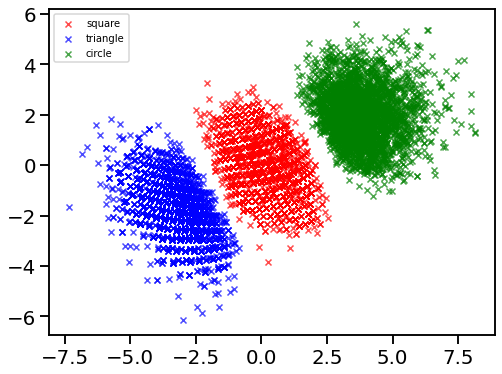

In [18]:
fig, ax = plt.subplots(figsize=(8,6))

cdict = {4.0: 'red', 3.0: 'blue', 500.0: 'green'}
ldict = {4.0: 'square', 3.0: 'triangle', 500.0: 'circle'}

for label, color in cdict.items():
    ax.scatter(acts_for_threeshapesn[label][:,0], acts_for_threeshapesn[label][:,1], 
               c = cdict[label], label = ldict[label], alpha=0.7, marker='x', s=36)

ax.legend(prop={'size': 10})

In [ ]:
plt.hist(acts_for_threeshapesn[4.0][:,0], label="Factor 4.0",color='limegreen')
plt.hist(acts_for_threeshapesn[3.0][:,0], label="Factor 3.0",color='orange')
plt.hist(acts_for_threeshapesn[500.0][:,0], label="Factor 500.0", color='cornflowerblue')
plt.legend(prop={'size': 10}, loc='upper left')

In [ ]:
plt.hist(acts_for_threeshapesn[4.0][:,1], label="Factor 4.0",color='limegreen')
plt.hist(acts_for_threeshapesn[3.0][:,1], label="Factor 3.0",color='orange')
plt.hist(acts_for_threeshapesn[500.0][:,1], label="Factor 500.0", color='cornflowerblue')
plt.legend(prop={'size': 10}, loc='upper left')

Visualizing latent space from -3.15 to 2.95, with center at 3.05
Visualizing latent space from 2.95 to 7.00, with center at 2.02
Visualizing latent space from 0.04 to 6.14, with center at 3.05
Visualizing latent space from 6.14 to 8.00, with center at 0.93
Visualizing latent space from -6.80 to -0.70, with center at 3.05
Visualizing latent space from -0.70 to 7.00, with center at 3.85


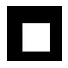

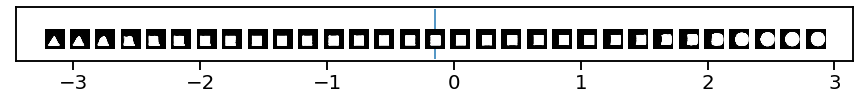

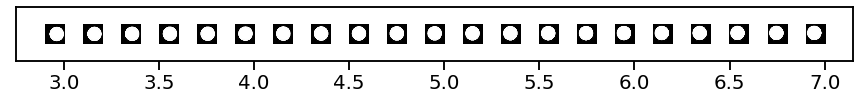

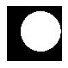

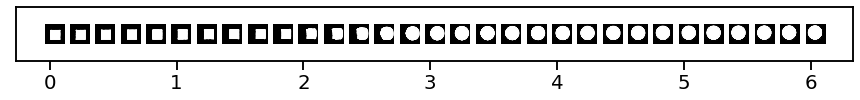

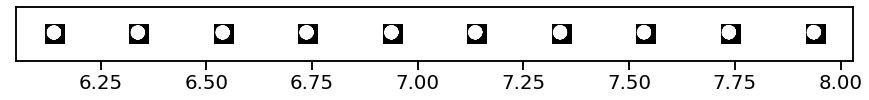

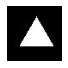

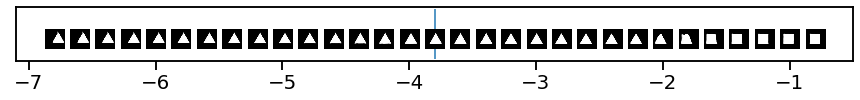

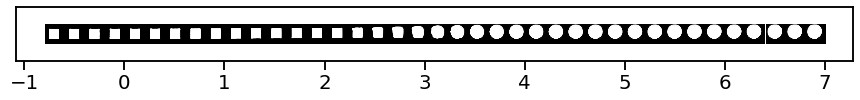

In [26]:
rnd_image = threeshapesn_dataset.__getitem__(101)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.axis('off')
ax.imshow(rnd_image.permute(1,2,0), cmap='gray')
rnd_image = rnd_image.unsqueeze(0).to(curr_dev)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative')

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
ax.vlines(ref,0,0.5)

traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative', 
                                                lb=2.95,ub=7)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)

rnd_image = threeshapesn_dataset.__getitem__(1000)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.axis('off')
ax.imshow(rnd_image.permute(1,2,0), cmap='gray')
rnd_image = rnd_image.unsqueeze(0).to(curr_dev)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative')

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
    
    
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative',
                                                lb=6.14 , ub=8.0)
fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
    
rnd_image = threeshapesn_dataset.__getitem__(800)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.axis('off')
ax.imshow(rnd_image.permute(1,2,0), cmap='gray')
rnd_image = rnd_image.unsqueeze(0).to(curr_dev)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative')
fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
ax.vlines(ref,0,0.5)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative',
                                                lb=-0.70, ub=7.0)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)

Visualizing latent space from -3.15 to 2.95, with center at 3.05
Visualizing latent space from 2.95 to 7.00, with center at 2.02
Visualizing latent space from 0.04 to 6.14, with center at 3.05
Visualizing latent space from 6.14 to 8.00, with center at 0.93
Visualizing latent space from -6.80 to -0.70, with center at 3.05
Visualizing latent space from -0.70 to 7.00, with center at 3.85


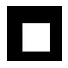

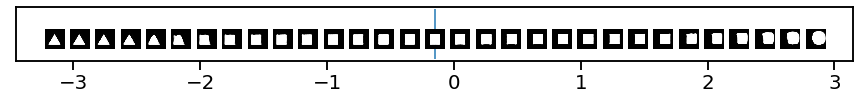

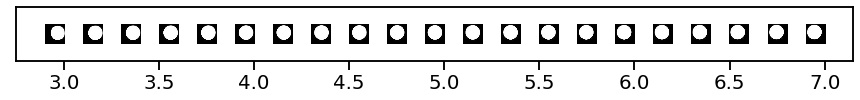

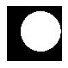

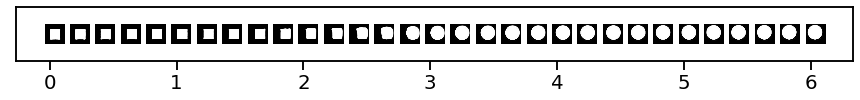

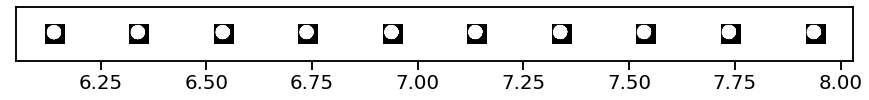

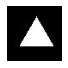

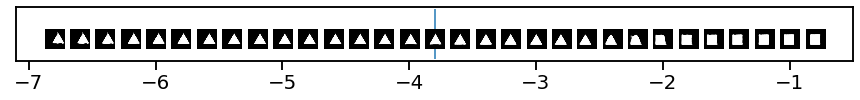

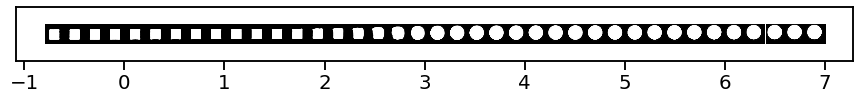

In [27]:
rnd_image = threeshapesn_dataset.__getitem__(101)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.axis('off')
ax.imshow(rnd_image.permute(1,2,0), cmap='gray')
rnd_image = rnd_image.unsqueeze(0).to(curr_dev)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative',
                                                fix_dim=1,fix_val=0)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
ax.vlines(ref,0,0.5)

traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative', 
                                                lb=2.95,ub=7,
                                                fix_dim=1,fix_val=0)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)

rnd_image = threeshapesn_dataset.__getitem__(1000)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.axis('off')
ax.imshow(rnd_image.permute(1,2,0), cmap='gray')
rnd_image = rnd_image.unsqueeze(0).to(curr_dev)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative',
                                                fix_dim=1,fix_val=0)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
    
    
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative',
                                                lb=6.14 , ub=8.0,
                                                fix_dim=1,fix_val=0)
fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
    
rnd_image = threeshapesn_dataset.__getitem__(800)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.axis('off')
ax.imshow(rnd_image.permute(1,2,0), cmap='gray')
rnd_image = rnd_image.unsqueeze(0).to(curr_dev)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative',
                                                fix_dim=1,fix_val=0)
fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
ax.vlines(ref,0,0.5)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative',
                                                lb=-0.70, ub=7.0,
                                                fix_dim=1,fix_val=0)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)

Visualizing latent space from -3.15 to 2.95, with center at 3.05
Visualizing latent space from 2.95 to 7.00, with center at 2.02
Visualizing latent space from 0.04 to 6.14, with center at 3.05
Visualizing latent space from 6.14 to 8.00, with center at 0.93
Visualizing latent space from -6.80 to -0.70, with center at 3.05
Visualizing latent space from -0.70 to 7.00, with center at 3.85


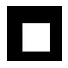

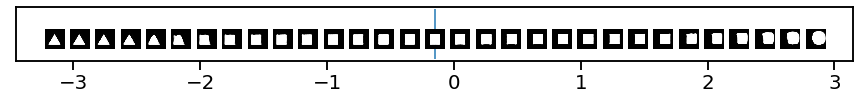

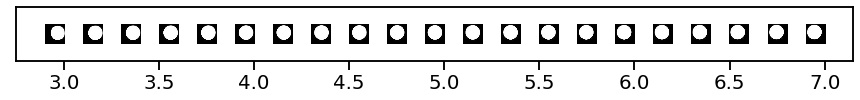

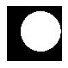

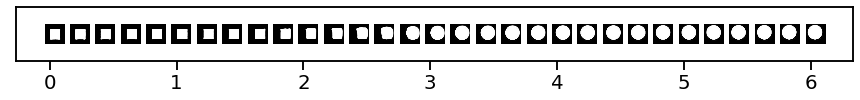

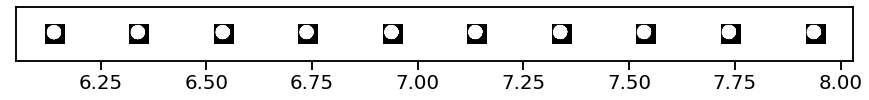

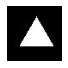

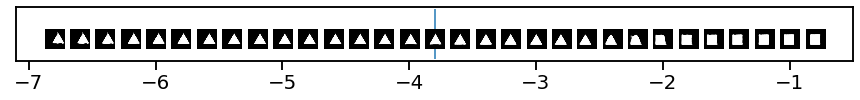

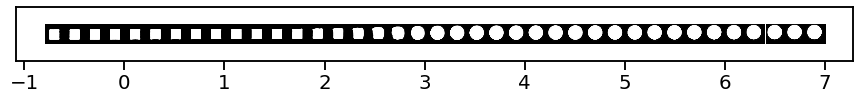

In [28]:
rnd_image = threeshapesn_dataset.__getitem__(101)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.axis('off')
ax.imshow(rnd_image.permute(1,2,0), cmap='gray')
rnd_image = rnd_image.unsqueeze(0).to(curr_dev)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative',
                                                fix_dim=1,fix_val=0)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
ax.vlines(ref,0,0.5)

traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative', 
                                                lb=2.95,ub=7,
                                                fix_dim=1,fix_val=0)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)

rnd_image = threeshapesn_dataset.__getitem__(1000)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.axis('off')
ax.imshow(rnd_image.permute(1,2,0), cmap='gray')
rnd_image = rnd_image.unsqueeze(0).to(curr_dev)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative',
                                                fix_dim=1,fix_val=0)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
    
    
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative',
                                                lb=6.14 , ub=8.0,
                                                fix_dim=1,fix_val=0)
fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
    
rnd_image = threeshapesn_dataset.__getitem__(800)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.axis('off')
ax.imshow(rnd_image.permute(1,2,0), cmap='gray')
rnd_image = rnd_image.unsqueeze(0).to(curr_dev)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative',
                                                fix_dim=1,fix_val=0)
fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
ax.vlines(ref,0,0.5)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=0, mode='relative',
                                                lb=-0.70, ub=7.0,
                                                fix_dim=1,fix_val=0)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)

### Traverse dim 1 with dim 0 fixed 

Visualizing latent space from -1.83 to 4.27, with center at 3.05
Visualizing latent space from 4.27 to 7.00, with center at 1.37
Visualizing latent space from -2.59 to 3.51, with center at 3.05
Visualizing latent space from 3.51 to 8.00, with center at 2.25
Visualizing latent space from -3.83 to 2.27, with center at 3.05
Visualizing latent space from 2.27 to 7.00, with center at 2.37


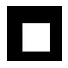

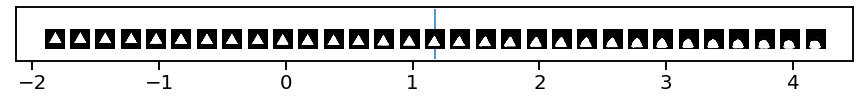

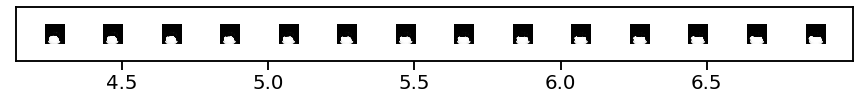

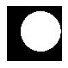

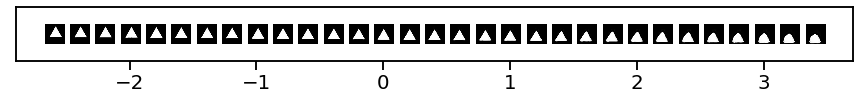

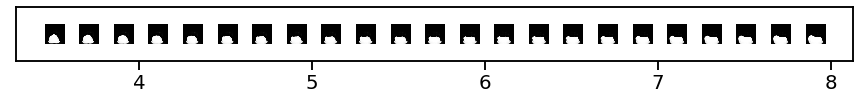

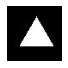

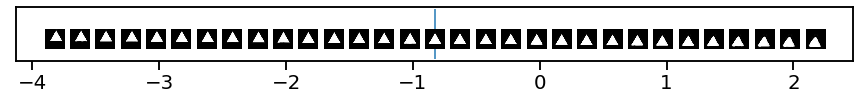

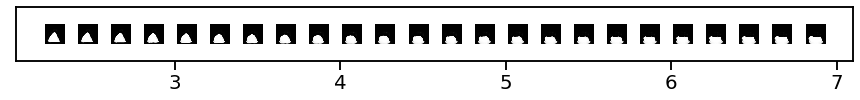

In [34]:
to_traverse = 1
dim_fixed = 0
dim_fixed_val = -3.25

rnd_image = threeshapesn_dataset.__getitem__(101)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.axis('off')
ax.imshow(rnd_image.permute(1,2,0), cmap='gray')
rnd_image = rnd_image.unsqueeze(0).to(curr_dev)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=to_traverse, mode='relative',
                                                fix_dim=dim_fixed, fix_val=dim_fixed_val)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
ax.vlines(ref,0,0.5)

traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=to_traverse, mode='relative', 
                                                lb=4.27,ub=7,
                                                fix_dim=dim_fixed, fix_val=dim_fixed_val)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)

rnd_image = threeshapesn_dataset.__getitem__(1000)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.axis('off')
ax.imshow(rnd_image.permute(1,2,0), cmap='gray')
rnd_image = rnd_image.unsqueeze(0).to(curr_dev)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=to_traverse, mode='relative',
                                                fix_dim=dim_fixed, fix_val=dim_fixed_val)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
    
    
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=to_traverse, mode='relative',
                                                lb=3.51 , ub=8.0,
                                                fix_dim=dim_fixed, fix_val=dim_fixed_val)
fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
    
rnd_image = threeshapesn_dataset.__getitem__(800)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.axis('off')
ax.imshow(rnd_image.permute(1,2,0), cmap='gray')
rnd_image = rnd_image.unsqueeze(0).to(curr_dev)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=to_traverse, mode='relative',
                                                fix_dim=dim_fixed, fix_val=dim_fixed_val)
fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
ax.vlines(ref,0,0.5)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=to_traverse, mode='relative',
                                                lb=2.27, ub=7.0,
                                                fix_dim=dim_fixed, fix_val=dim_fixed_val)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)

Visualizing latent space from -1.83 to 4.27, with center at 3.05
Visualizing latent space from 4.27 to 7.00, with center at 1.37
Visualizing latent space from -2.59 to 3.51, with center at 3.05
Visualizing latent space from 3.51 to 8.00, with center at 2.25
Visualizing latent space from -3.83 to 2.27, with center at 3.05
Visualizing latent space from 2.27 to 7.00, with center at 2.37


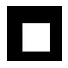

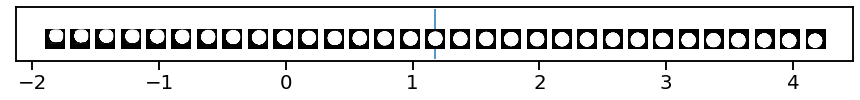

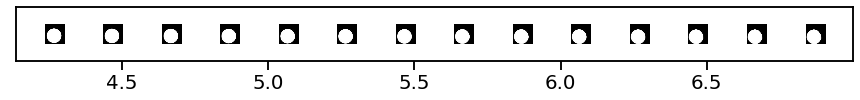

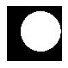

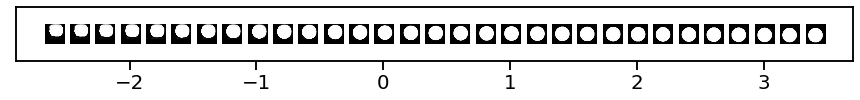

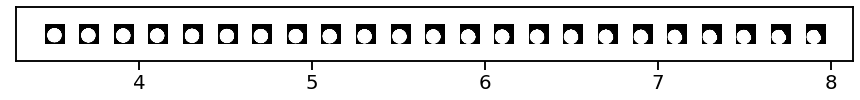

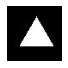

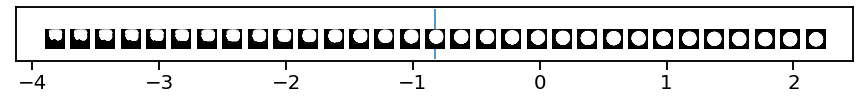

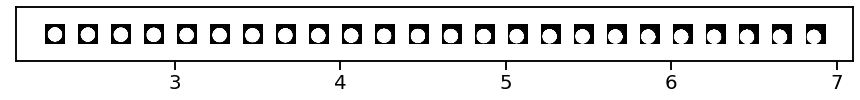

In [35]:
to_traverse = 1
dim_fixed = 0
dim_fixed_val = 4

rnd_image = threeshapesn_dataset.__getitem__(101)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.axis('off')
ax.imshow(rnd_image.permute(1,2,0), cmap='gray')
rnd_image = rnd_image.unsqueeze(0).to(curr_dev)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=to_traverse, mode='relative',
                                                fix_dim=dim_fixed, fix_val=dim_fixed_val)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
ax.vlines(ref,0,0.5)

traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=to_traverse, mode='relative', 
                                                lb=4.27,ub=7,
                                                fix_dim=dim_fixed, fix_val=dim_fixed_val)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)

rnd_image = threeshapesn_dataset.__getitem__(1000)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.axis('off')
ax.imshow(rnd_image.permute(1,2,0), cmap='gray')
rnd_image = rnd_image.unsqueeze(0).to(curr_dev)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=to_traverse, mode='relative',
                                                fix_dim=dim_fixed, fix_val=dim_fixed_val)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
    
    
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=to_traverse, mode='relative',
                                                lb=3.51 , ub=8.0,
                                                fix_dim=dim_fixed, fix_val=dim_fixed_val)
fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
    
rnd_image = threeshapesn_dataset.__getitem__(800)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.axis('off')
ax.imshow(rnd_image.permute(1,2,0), cmap='gray')
rnd_image = rnd_image.unsqueeze(0).to(curr_dev)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=to_traverse, mode='relative',
                                                fix_dim=dim_fixed, fix_val=dim_fixed_val)
fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)
ax.vlines(ref,0,0.5)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesn, rnd_image, limit=2, 
                                            inter=1/5, dim_to_explore=to_traverse, mode='relative',
                                                lb=2.27, ub=7.0,
                                                fix_dim=dim_fixed, fix_val=dim_fixed_val)

fig, ax = plt.subplots(figsize=(15,1))
ax.set_yticklabels([])
ax.set_yticks([])
for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.3,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)

# $\beta$-VAE on 3shapesNoisy ($\beta =4$)

In [ ]:
beta = 4.0
z_dim = 2
batch_size = 64
checkpoint_path="../pl-dt-test/3shapesnoisy_beta4/version_0/checkpoints/epoch=99-step=6999.ckpt"


acts_for_threeshapesnb4, threeshapesn_datasetb4, model_threeshapesnb4 = load_model_and_data_and_get_activations(
                    dset_name='threeshapesnoisy', dset_path='../datasets', 
                    batch_size=batch_size, z_dim=z_dim , beta=beta, 
                    checkpoint_path=checkpoint_path, current_device=curr_dev, 
                    activation_with_label=True, seed=123,  batches=None
    )


In [ ]:
plt.hist(acts_for_threeshapesnb4[4.0][:,0], label="Factor 4.0",color='limegreen')
plt.hist(acts_for_threeshapesnb4[3.0][:,0], label="Factor 3.0",color='orange')
plt.hist(acts_for_threeshapesnb4[500.0][:,0], label="Factor 500.0", color='cornflowerblue')
plt.legend(prop={'size': 10}, loc='upper left')

In [ ]:
plt.hist(acts_for_threeshapesnb4[4.0][:,1], label="Factor 4.0",color='limegreen')
plt.hist(acts_for_threeshapesnb4[3.0][:,1], label="Factor 3.0",color='orange')
plt.hist(acts_for_threeshapesnb4[500.0][:,1], label="Factor 500.0", color='cornflowerblue')
plt.legend(prop={'size': 10}, loc='upper left')

In [ ]:
rnd_image = threeshapesn_datasetb4.__getitem__(200)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.imshow(rnd_image.permute(1,2,0), cmap='gray')
rnd_image = rnd_image.unsqueeze(0).to(curr_dev)
traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesnb4, rnd_image, limit=2, 
                                            inter=1/5, loc=0, mode='relative')

fig, ax = plt.subplots(figsize=(15,1))

for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.4,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)

ax.vlines(ref,0,0.5)

traverse_maps, ref = do_latent_traversal_scatter(model_threeshapesnb4, rnd_image, limit=2, 
                                            inter=1/5, loc=1, mode='relative')

fig, ax = plt.subplots(figsize=(15,1))

for z, img in traverse_maps:
    ax.scatter(z, 0.2) 
    ab = AnnotationBbox(OffsetImage(img.squeeze(0).cpu().permute(1,2,0), zoom=0.4,cmap='gray'), 
                        (z, 0.2), 
                        frameon=False)
    ax.add_artist(ab)

ax.vlines(ref,0,0.5)

# $\beta$-VAE on dsprites_full

In [ ]:
beta = 1.0
z_dim = 6
batch_size = 256
checkpoint_path="../pl-dt-test/dsprites_full_beta1/version_0/checkpoints/epoch=51-step=539135.ckpt"


acts_for_dsprites_full, dsprites_full_dataset, model_dsprites_full  = load_model_and_data_and_get_activations(
                    dset_name='dsprites_full', dset_path='../datasets', 
                    batch_size=batch_size, z_dim=z_dim , beta=beta, 
                    checkpoint_path=checkpoint_path, current_device=curr_dev, 
                    activation_with_label=False, seed=123,  batches=2000
    )


In [ ]:
fig, axes = plt.subplots(6, figsize=(10,15))

for a in range(6):
    axes[a].hist(acts_for_dsprites_full[a], label=f"Factor {a}", color='limegreen')
    axes[a].tick_params(axis='both', which='major', labelsize=10)
    axes[a].legend(prop={'size': 10}, loc='upper left')
    axes[a].set_xlim(-5,5)

In [ ]:
anchor_image = dsprites_full_dataset.__getitem__(100)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.imshow(anchor_image.permute(1,2,0), cmap='gray')
anchor_image = anchor_image.unsqueeze(0).to(curr_dev)

In [ ]:
show_traversal_plot(model_dsprites_full, anchor_image, limit=2, interp_step=1/5, dim=0, mode='relative')
show_traversal_plot(model_dsprites_full, anchor_image, limit=2, interp_step=1/5, dim=1, mode='relative')
show_traversal_plot(model_dsprites_full, anchor_image, limit=2, interp_step=1/5, dim=2, mode='relative')
show_traversal_plot(model_dsprites_full, anchor_image, limit=2, interp_step=1/5, dim=3, mode='relative')
show_traversal_plot(model_dsprites_full, anchor_image, limit=2, interp_step=1/5, dim=4, mode='relative')
show_traversal_plot(model_dsprites_full, anchor_image, limit=2, interp_step=1/5, dim=5, mode='relative')

# $\beta$-VAE on dsprites_full ($\beta = 4$)


In [ ]:
beta = 4.0
z_dim = 6
batch_size = 256
checkpoint_path="../pl-dt-test/dsprites_full_beta4/version_0/checkpoints/epoch=60-step=316223.ckpt"

acts_for_dsprites_full, dsprites_full_dataset, model_dsprites_full  = load_model_and_data_and_get_activations(
                    dset_name='dsprites_full', dset_path='../datasets', 
                    batch_size=batch_size, z_dim=z_dim , beta=beta, 
                    checkpoint_path=checkpoint_path, current_device=curr_dev, 
                    activation_with_label=False, seed=123,  batches=2000
    )


In [ ]:
fig, axes = plt.subplots(6, figsize=(10,15))

for a in range(6):
    axes[a].hist(acts_for_dsprites_full[a], label=f"Factor {a}", color='limegreen')
    axes[a].tick_params(axis='both', which='major', labelsize=10)
    axes[a].legend(prop={'size': 10}, loc='upper left')
    axes[a].set_xlim(-5,5)

In [ ]:
anchor_image = dsprites_full_dataset.__getitem__(100)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.imshow(anchor_image.permute(1,2,0), cmap='gray')
anchor_image = anchor_image.unsqueeze(0).to(curr_dev)

In [ ]:
show_traversal_plot(model_dsprites_full, anchor_image, limit=2, interp_step=1/5, dim=0, mode='relative')
show_traversal_plot(model_dsprites_full, anchor_image, limit=2, interp_step=1/5, dim=1, mode='relative')
show_traversal_plot(model_dsprites_full, anchor_image, limit=2, interp_step=1/5, dim=2, mode='relative')
show_traversal_plot(model_dsprites_full, anchor_image, limit=2, interp_step=1/5, dim=3, mode='relative')
show_traversal_plot(model_dsprites_full, anchor_image, limit=2, interp_step=1/5, dim=4, mode='relative')
show_traversal_plot(model_dsprites_full, anchor_image, limit=2, interp_step=1/5, dim=5, mode='relative')

# $\beta$-VAE on dsprites_correlated

In [ ]:
beta = 1.0
z_dim = 6
batch_size = 144
checkpoint_path="../pl-dt-test/dsprites_colored_beta1_working/version_4/checkpoints/epoch=55-step=290303.ckpt"


acts_for_dsprites_corr, dsprites_corr_dataset, model_dsprites_corr  = load_model_and_data_and_get_activations(
                    dset_name='dsprites_colored', dset_path='../datasets', 
                    batch_size=batch_size, z_dim=z_dim , beta=beta, 
                    checkpoint_path=checkpoint_path, current_device=curr_dev, 
                    activation_with_label=False, seed=123,  batches=2000, in_channels=3
    )

In [ ]:
fig, axes = plt.subplots(6, figsize=(10,15))

for a in range(6):
    axes[a].hist(acts_for_dsprites_corr[a], label=f"Factor {a}", color='limegreen')
    axes[a].tick_params(axis='both', which='major', labelsize=10)
    axes[a].legend(prop={'size': 10}, loc='upper left')
    axes[a].set_xlim(-5,5)

In [ ]:
anchor_image = dsprites_corr_dataset.__getitem__(200)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.imshow(anchor_image.permute(1,2,0), cmap='gray')
anchor_image = anchor_image.unsqueeze(0).to(curr_dev)
show_traversal_plot(model_dsprites_corr, anchor_image, limit=2, interp_step=1/5, dim=0, mode='relative')
show_traversal_plot(model_dsprites_corr, anchor_image, limit=2, interp_step=1/5, dim=1, mode='relative')
show_traversal_plot(model_dsprites_corr, anchor_image, limit=2, interp_step=1/5, dim=2, mode='relative')
show_traversal_plot(model_dsprites_corr, anchor_image, limit=2, interp_step=1/5, dim=3, mode='relative')
show_traversal_plot(model_dsprites_corr, anchor_image, limit=2, interp_step=1/5, dim=4, mode='relative')
show_traversal_plot(model_dsprites_corr, anchor_image, limit=2, interp_step=1/5, dim=5, mode='relative')

In [ ]:
anchor_image = dsprites_corr_dataset.__getitem__(5)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.imshow(anchor_image.permute(1,2,0), cmap='gray')
anchor_image = anchor_image.unsqueeze(0).to(curr_dev)
show_traversal_plot(model_dsprites_corr, anchor_image, limit=2, interp_step=1/5, dim=0, mode='relative')
show_traversal_plot(model_dsprites_corr, anchor_image, limit=2, interp_step=1/5, dim=1, mode='relative')
show_traversal_plot(model_dsprites_corr, anchor_image, limit=2, interp_step=1/5, dim=2, mode='relative')
show_traversal_plot(model_dsprites_corr, anchor_image, limit=2, interp_step=1/5, dim=3, mode='relative')
show_traversal_plot(model_dsprites_corr, anchor_image, limit=2, interp_step=1/5, dim=4, mode='relative')
show_traversal_plot(model_dsprites_corr, anchor_image, limit=2, interp_step=1/5, dim=5, mode='relative')

# $\beta$-VAE on dsprites_correlated ($\beta = 4$)

In [ ]:
beta = 4.0
z_dim = 6
batch_size = 144
checkpoint_path="../pl-dt-test/dsprites_colored_beta4/version_0/checkpoints/epoch=49-step=259199.ckpt"


acts_for_dsprites_corrb4, dsprites_corr_datasetb4, model_dsprites_corrb4  = load_model_and_data_and_get_activations(
                    dset_name='dsprites_colored', dset_path='../datasets', 
                    batch_size=batch_size, z_dim=z_dim , beta=beta, 
                    checkpoint_path=checkpoint_path, current_device=curr_dev, 
                    activation_with_label=False, seed=123,  batches=2000, in_channels=3
    )

In [ ]:
fig, axes = plt.subplots(6, figsize=(10,15))

for a in range(6):
    axes[a].hist(acts_for_dsprites_corrb4[a], label=f"Factor {a}", color='limegreen')
    axes[a].tick_params(axis='both', which='major', labelsize=10)
    axes[a].legend(prop={'size': 10}, loc='upper left')
    axes[a].set_xlim(-5,5)

In [ ]:
anchor_image = dsprites_corr_datasetb4.__getitem__(200)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.imshow(anchor_image.permute(1,2,0), cmap='gray')
anchor_image = anchor_image.unsqueeze(0).to(curr_dev)
show_traversal_plot(model_dsprites_corrb4, anchor_image, limit=2, interp_step=1/5, dim=0, mode='relative')
show_traversal_plot(model_dsprites_corrb4, anchor_image, limit=2, interp_step=1/5, dim=1, mode='relative')
show_traversal_plot(model_dsprites_corrb4, anchor_image, limit=2, interp_step=1/5, dim=2, mode='relative')
show_traversal_plot(model_dsprites_corrb4, anchor_image, limit=2, interp_step=1/5, dim=3, mode='relative')
show_traversal_plot(model_dsprites_corrb4, anchor_image, limit=2, interp_step=1/5, dim=4, mode='relative')
show_traversal_plot(model_dsprites_corrb4, anchor_image, limit=2, interp_step=1/5, dim=5, mode='relative')

In [ ]:
anchor_image = dsprites_corr_datasetb4.__getitem__(5)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.imshow(anchor_image.permute(1,2,0), cmap='gray')
anchor_image = anchor_image.unsqueeze(0).to(curr_dev)
show_traversal_plot(model_dsprites_corrb4, anchor_image, limit=2, interp_step=1/5, dim=0, mode='relative')
show_traversal_plot(model_dsprites_corrb4, anchor_image, limit=2, interp_step=1/5, dim=1, mode='relative')
show_traversal_plot(model_dsprites_corrb4, anchor_image, limit=2, interp_step=1/5, dim=2, mode='relative')
show_traversal_plot(model_dsprites_corrb4, anchor_image, limit=2, interp_step=1/5, dim=3, mode='relative')
show_traversal_plot(model_dsprites_corrb4, anchor_image, limit=2, interp_step=1/5, dim=4, mode='relative')
show_traversal_plot(model_dsprites_corrb4, anchor_image, limit=2, interp_step=1/5, dim=5, mode='relative')